# BoXYZ - Depth Map Processing

Process the depth map to create a 3D point cloud and visualize it using Open3D


In [1]:
!pip install --quiet numpy matplotlib open3d


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [24]:
import os
import copy 

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from IPython.display import display

INTERACTIVE_VISUALIZATION = True
BBOX_COLORS = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [0.5, 0.5, 0.5],
    [1, 0.5, 0],
]

In [25]:
# get pcb from depth map
intrinsics_filename = os.path.join('..', 'assets', 'intrinsics.npy')
K = np.load(intrinsics_filename)
extrinsics_filename = os.path.join('..', 'assets', 'extrinsics.npy')
extrinsic_matrix = np.load(extrinsics_filename)
depth_filename = os.path.join('..', 'assets', 'one-box.depth.npdata.npy')
xyz = np.load(depth_filename)
print('Depth map shape', xyz.shape)
h, w = xyz.shape
v, u = np.mgrid[0:h, 0:w]
u = u.flatten()
v = v.flatten()
z = xyz.flatten()
valid = z > 0
u = u[valid]
v = v[valid]
z = z[valid]
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]
x = (u - cx) * z / fx
y = (v - cy) * z / fy
xyz = np.column_stack([x, y, z])
        
pcb = o3d.geometry.PointCloud()
pcb.points = o3d.utility.Vector3dVector(xyz)

extrinsic_matrix_meters = extrinsic_matrix.copy()
# TODO (fabawi): check if is this right. Is it in m instead of mm? Looks wrong but not important anyway
extrinsic_matrix_meters[:3, 3] = extrinsic_matrix_meters[:3, 3] / 1000.0
camera_world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
camera_to_world = np.linalg.inv(extrinsic_matrix_meters)
camera_world_frame.transform(camera_to_world)

Depth map shape (1544, 2064)


TriangleMesh with 1134 points and 2240 triangles.

In [26]:
# add colors to pcb
color_filename = os.path.join('..', 'assets', 'one-box.color.npdata.npy')
pcb_col = np.load(color_filename)
print('Color data shape', pcb_col.shape)

colors = pcb_col.reshape(-1, 3)
colors = colors / 255.0
pcb.colors = o3d.utility.Vector3dVector(colors)

Color data shape (1544, 2064)


In [27]:
# TODO (fabawi): check if this is necessary. Leave it for now
# pcb.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# pcb.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 0.]))


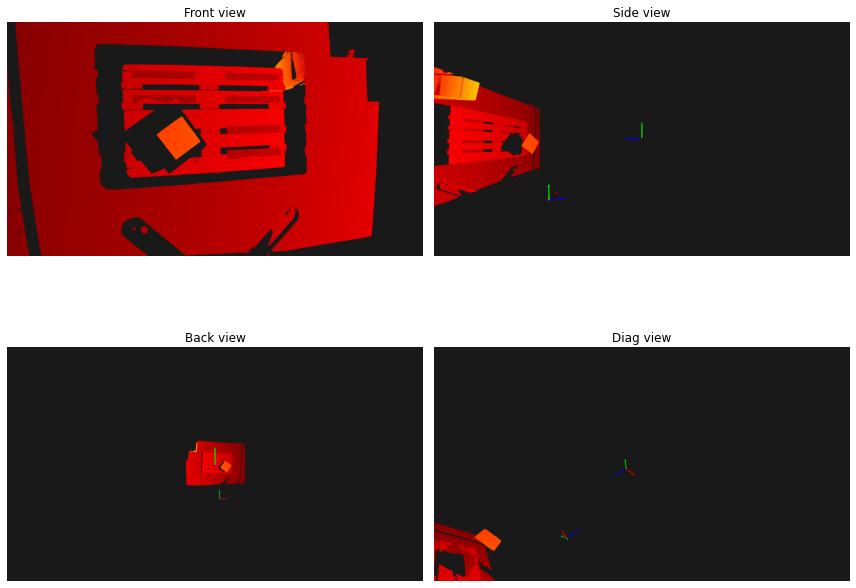

In [28]:
# visualize the pcb in notebook
def capture_pcb_snapshots(pcb):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Point Cloud Visualization', visible=False)
    vis.add_geometry(pcb)
    
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
    vis.add_geometry(camera_frame)
    vis.add_geometry(camera_world_frame)
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    snapshots = []
    view_names = ["Front view", "Side view", "Back view", "Diag view"]
    
    ctr = vis.get_view_control()
    ctr.change_field_of_view(step=60)
    vis.poll_events()
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(do_render=True)
    snapshots.append(np.asarray(img))
    
    view_angles = [
        (0, np.pi/2, 0),
        (0, np.pi, 0),
        (np.pi/4, np.pi/4, 0)
    ]
    
    view_translations = [
        [0, 0, 0],
        [0, 0, 0],
        [0.5, 0.5, 0]
    ]
        
    for i, ((pitch, yaw, roll), translation) in enumerate(zip(view_angles, view_translations)):
        ctr = vis.get_view_control()
        ctr.change_field_of_view(step=60)
        ctr.set_front([np.sin(yaw) * np.cos(pitch), np.sin(pitch), np.cos(yaw) * np.cos(pitch)])
        ctr.set_lookat([0 + translation[0], 0 + translation[1], 0 + translation[2]])
        ctr.set_up([0, 1, 0])
        vis.poll_events()
        vis.update_renderer()
        img = vis.capture_screen_float_buffer(do_render=True)
        snapshots.append(np.asarray(img))
        
    vis.destroy_window()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (img, view_name) in enumerate(zip(snapshots, view_names)):
        axes[i].imshow(img)
        axes[i].set_title(f'{view_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# visualize pcb in interactive window
def visualize_pcb_interactive(pcb):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Point Cloud Visualization')
    vis.add_geometry(pcb)
    
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])
    vis.add_geometry(camera_frame)
    vis.add_geometry(camera_world_frame)
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    vis.run()
    vis.destroy_window()

def generate_3d_scene(pcb, visualize=False):
    o3d.io.write_point_cloud(os.path.join('..', 'assets', 'one-box.pcb.ply'), pcb)
    if visualize:
        visualize_pcb_interactive(pcb)
    capture_pcb_snapshots(pcb)
    
generate_3d_scene(pcb, visualize=INTERACTIVE_VISUALIZATION)

Cluster 0 - Box center: [-0.09748978  0.02411997  2.54387329]
Cluster 0 - Box dimensions: [2.45285942 1.79438989 0.7511141 ]
Cluster 1 - Box center: [-0.08679475  0.06453713  2.63386248]
Cluster 1 - Box dimensions: [1.30837132 0.95883601 0.03602923]
Cluster 2 - Box center: [-0.41326479 -0.09928235  2.48951275]
Cluster 2 - Box dimensions: [0.31139237 0.31756038 0.30521786]
Cluster 3 - Box center: [ 0.19240752 -0.0459619   2.72958968]
Cluster 3 - Box dimensions: [0.3585126  0.05176635 0.01510832]
Cluster 4 - Box center: [0.18263642 0.29067811 2.73764093]
Cluster 4 - Box dimensions: [0.35555172 0.04535274 0.00435268]
Cluster 5 - Box center: [-0.60724135 -0.29848468  2.67570776]
Cluster 5 - Box dimensions: [0.30932867 0.15926294 0.0308309 ]
Cluster 6 - Box center: [0.16320555 0.14591071 2.73842241]
Cluster 6 - Box dimensions: [0.20231573 0.04256223 0.0037131 ]
Cluster 7 - Box center: [-0.38246362  0.27074134  2.79727533]
Cluster 7 - Box dimensions: [0.19862012 0.04525576 0.00511445]


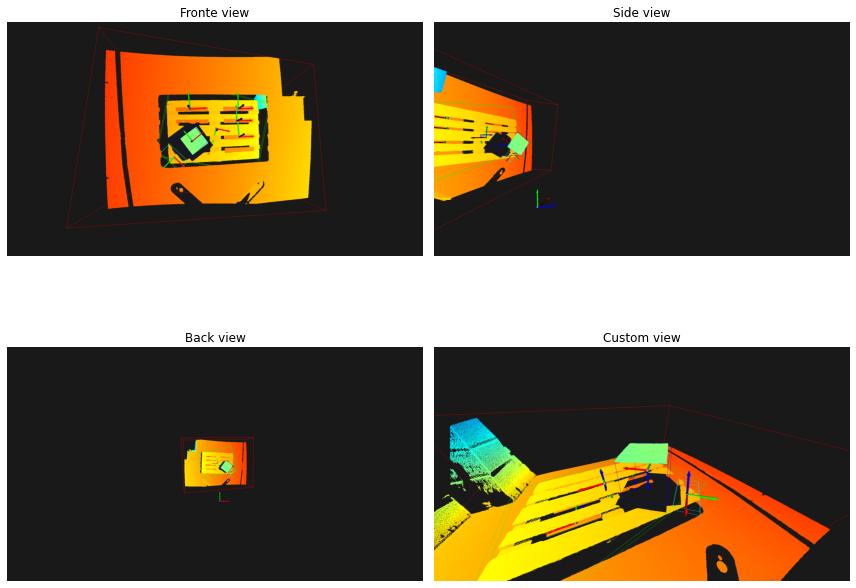

In [29]:
# check if box is above palette
def extend_bbox_to_palette(palette_top, obb):
    obb_bottom = obb.center[2] + obb.extent[2]/2 
    if obb_bottom > palette_top:
        return obb.center[2], obb.extent[2]
    else:
        obb_center_z = obb.center[2] + (palette_top - obb_bottom)/2
        obb_extent_z = palette_top - obb_bottom
    return obb_center_z, obb_extent_z


# visualize pcb with bboxes in interactive window
def visualize_box_detection(pcb, boxes, box_clouds):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Box Detection')
    vis.add_geometry(pcb)
    
    for i, (obb, cloud) in enumerate(zip(boxes, box_clouds)):
        vis.add_geometry(obb)
        
        center = obb.get_center()
        R = obb.R
        extent = obb.extent
        
        print(f"Cluster {i} - Box center: {center}")
        print(f"Cluster {i} - Box dimensions: {extent}")
        
        box_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=center)
        box_frame.rotate(R, center=center)
        vis.add_geometry(box_frame)
        vis.add_geometry(camera_world_frame)

    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    vis.run()
    vis.destroy_window()

# visualize the bboxes in the notebook
def capture_box_detection_snapshots(pcb, boxes):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Box Detection Snapshots', visible=False)
    vis.add_geometry(pcb)
    
    for i, obb in enumerate(boxes):
        vis.add_geometry(obb)
        
        box_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2, origin=obb.get_center())
        box_frame.rotate(obb.R, center=obb.get_center())
        vis.add_geometry(box_frame)
        vis.add_geometry(camera_world_frame)
    
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    snapshots = []
    view_names = ["Fronte view", "Side view", "Back view", "Custom view"]
    
    ctr = vis.get_view_control()
    ctr.change_field_of_view(step=60)
    vis.poll_events()
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(do_render=True)
    snapshots.append(np.asarray(img))
    
    view_angles = [
        (0, np.pi/2, 0),
        (0, np.pi, 0),
        (0, 0, 0)
    ]
    
    view_translations = [
        [0, 0, 0],
        [0, 0, 0],
        [0.5, 0.3, 0.3]
    ]
    
    for i, ((pitch, yaw, roll), translation) in enumerate(zip(view_angles, view_translations)):
        ctr = vis.get_view_control()
        ctr.change_field_of_view(step=60)
        
        if i == 2:  # custom view
            camera_params = o3d.camera.PinholeCameraParameters()
            camera_params.extrinsic = np.array([
                [-0.89818829, -0.40778351, 0.16422669, -0.7810453],
                [0.34819119, -0.43184673, 0.83202842, -1.92402076],
                [-0.26836671, 0.80450047, 0.52986631, -0.49629674],
                [0., 0., 0., 1.]
            ])
            camera_params.intrinsic = vis.get_view_control().convert_to_pinhole_camera_parameters().intrinsic
            
            ctr.convert_from_pinhole_camera_parameters(camera_params)
        else:
            ctr.set_front([np.sin(yaw) * np.cos(pitch), np.sin(pitch), np.cos(yaw) * np.cos(pitch)])
            ctr.set_lookat([0 + translation[0], 0 + translation[1], 0 + translation[2]])
            ctr.set_up([0, 1, 0])
        
        vis.poll_events()
        vis.update_renderer()
        img = vis.capture_screen_float_buffer(do_render=True)
        snapshots.append(np.asarray(img))
        
    vis.destroy_window()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (img, view_name) in enumerate(zip(snapshots, view_names)):
        axes[i].imshow(img)
        axes[i].set_title(f'{view_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# detect the bboxes (with poses)
def detect_box_pose(pcb, visualize=False):
    pcd_downsampled = pcb.voxel_down_sample(voxel_size=0.01)
    
    pcd_cleaned, _ = pcd_downsampled.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.001)
    
    # TODO (fabawi): outlier removal of points, but does not deal with artefacts like the corner of the pallet. 
    #                Maybe it can be shape-based filtering? But are all cartons cuboids? Maybe irregular shapes
    #                can be expected? Leave it for now
    plane_model, inliers = pcd_cleaned.segment_plane(distance_threshold=0.03,
                                                         ransac_n=3,
                                                         num_iterations=1000)
    
    pallet_plane = pcd_downsampled.select_by_index(inliers)
    remaining = pcd_downsampled.select_by_index(inliers, invert=True)
    
    labels = np.array(remaining.cluster_dbscan(eps=0.1, min_points=100))
    
    if len(np.unique(labels[labels >= 0])) == 0:
        return None, None
    
    cluster_sizes = [(labels == i).sum() for i in range(max(labels) + 1)]
    sorted_cluster_sizes = np.argsort(cluster_sizes)[::-1]
    
    boxes = []
    box_clouds = []
    
    palette_obb_top = None
    
    for i, cluster_idx in enumerate(sorted_cluster_sizes):
        cluster_cloud = remaining.select_by_index(np.where(labels == cluster_idx)[0])
        obb = cluster_cloud.get_oriented_bounding_box()
        if i == 1:
            palette_obb_top = obb.center[2] + obb.extent[2]/2 
        elif palette_obb_top:
            obb_center_z, obb_extent_z = extend_bbox_to_palette(palette_obb_top, obb)
            new_extent = np.array([obb.extent[0], obb.extent[1], obb_extent_z])
            new_center = np.array([obb.center[0], obb.center[1], obb_center_z])
            obb = o3d.geometry.OrientedBoundingBox(new_center, obb.R, new_extent)
                
        
        obb.color = BBOX_COLORS[i % len(BBOX_COLORS)]
        boxes.append(obb)
        box_clouds.append(cluster_cloud)
    
    if visualize and boxes:
        visualize_box_detection(pcb, boxes, box_clouds)
    
    capture_box_detection_snapshots(pcb, boxes)
    return boxes, box_clouds

box_pose, box_points = detect_box_pose(pcb, visualize=INTERACTIVE_VISUALIZATION)

In [33]:
# get transformation matrices (camera to object)
camera_to_world = extrinsic_matrix
box_poses_camera_to_object = []

for i, obb in enumerate(box_pose):
    object_in_camera = np.eye(4)
    object_in_camera[:3, :3] = obb.R
    object_in_camera[:3, 3] = obb.center
    
    object_in_world = camera_to_world @ object_in_camera
    camera_to_object = np.linalg.inv(camera_to_world) @ object_in_world
    
    box_poses_camera_to_object.append(camera_to_object)
    
    print(f"Box {i} transformation matrix (camera to object):")
    if i == 2:
        print("\n<------------------------- This is the carton box ----------------------->\n")
    print(camera_to_object)
    if i == 2:
        print("<-------------------------xxxxxxxxxxxxxxxxxxxxxxx ----------------------->")
    
    print()
    

Box 0 transformation matrix (camera to object):
[[ 0.98583355  0.02300638  0.16614128 -0.09748978]
 [-0.04225141  0.99266798  0.11324796  0.02411997]
 [-0.1623177  -0.11866334  0.97957745  2.54387329]
 [ 0.          0.          0.          1.        ]]

Box 1 transformation matrix (camera to object):
[[ 0.97419447 -0.19858    -0.10728987 -0.08679475]
 [-0.19830032 -0.98005001  0.01337739  0.06453713]
 [-0.10780592  0.00824343 -0.99413778  2.63386248]
 [ 0.          0.          0.          1.        ]]

Box 2 transformation matrix (camera to object):

<------------------------- This is the carton box ----------------------->

[[ 0.76130147 -0.63856618  0.11248696 -0.41326479]
 [ 0.64384248  0.7650186  -0.01460813 -0.09928235]
 [-0.07672636  0.08354507  0.99354581  2.48951275]
 [ 0.          0.          0.          1.        ]]
<-------------------------xxxxxxxxxxxxxxxxxxxxxxx ----------------------->

Box 3 transformation matrix (camera to object):
[[ 0.99287065 -0.05757528  0.10436931 

In [34]:
# create meshes for carton boxes
def create_box_mesh(idx, box_pose):
    width=box_pose[idx].extent[0]
    height=box_pose[idx].extent[1]
    depth=box_pose[idx].extent[2]
    box = o3d.geometry.TriangleMesh.create_box(width=width, 
                                               height=height, 
                                               depth=depth)
    box.translate([-width/2, -height/2, -depth/2])
    return box

# visualize the boxes as meshes
def visualize_boxes(box_poses):
    # Create visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    for i, pose_matrix in enumerate(box_poses):
        if i > 1:
            box = create_box_mesh(i, box_pose)
            box.paint_uniform_color(BBOX_COLORS[i % len(BBOX_COLORS)])
            box.transform(pose_matrix)
            vis.add_geometry(box)
    
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    vis.add_geometry(coord_frame)
    
    view_control = vis.get_view_control()
    view_control.set_front([0.5, 0.5, -1])
    view_control.set_up([0, -1, 0])
    view_control.set_lookat([0, 0, 1])
    view_control.set_zoom(0.5)
    
    vis.run()
    vis.destroy_window()

if INTERACTIVE_VISUALIZATION:
    visualize_boxes(box_poses_camera_to_object)

In [10]:
### THROWAWAY - Just need to get the angle of view. Don't need it anymore
def get_camera_parameters_interactive(pcb):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Adjust View - Close Window When Done')
    vis.add_geometry(pcb)
    
    opt = vis.get_render_option()
    opt.background_color = np.array([0.1, 0.1, 0.1])
    opt.point_size = 2.0
    
    vis.run()
    
    ctr = vis.get_view_control()
    camera_params = ctr.convert_to_pinhole_camera_parameters()
    
    vis.destroy_window()
    extrinsic = camera_params.extrinsic
    intrinsic = camera_params.intrinsic
    
    rotation_matrix = extrinsic[:3, :3]
    sy = np.sqrt(rotation_matrix[0, 0]**2 + rotation_matrix[1, 0]**2)
    
    if sy > 1e-6:  # Not at singularity
        x = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
        y = np.arctan2(-rotation_matrix[2, 0], sy)
        z = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    else:
        x = np.arctan2(-rotation_matrix[1, 2], rotation_matrix[1, 1])
        y = np.arctan2(-rotation_matrix[2, 0], sy)
        z = 0
    
    angles_deg = np.degrees([x, y, z])
    
    print("Camera Extrinsic Matrix:")
    print(extrinsic)
    print("\nCamera Position:", -rotation_matrix.T @ extrinsic[:3, 3])
    print("\nCamera Angles (degrees):")
    print(f"  Pitch (X): {angles_deg[0]:.2f}°")
    print(f"  Yaw (Y): {angles_deg[1]:.2f}°")
    print(f"  Roll (Z): {angles_deg[2]:.2f}°")
    
    return camera_params
camera_params = get_camera_parameters_interactive(pcb)

Camera Extrinsic Matrix:
[[ 1.          0.          0.          0.05910108]
 [-0.         -1.         -0.          0.03379583]
 [-0.         -0.         -1.          5.36192197]
 [ 0.          0.          0.          1.        ]]

Camera Position: [-0.05910108  0.03379583  5.36192197]

Camera Angles (degrees):
  Pitch (X): -180.00°
  Yaw (Y): 0.00°
  Roll (Z): -0.00°
